<a href="https://colab.research.google.com/github/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/blob/main/07_milestone_project_1_food_vision_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: Food Vision 101

## Check GPU

In [49]:
# !nvidia-smi -L

## Get helper functions

We've created a bunch of helper functions to do small tasks required for our notebooks.

In [50]:
# Download helper functions script
!wget https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py

--2025-06-20 18:20:03--  https://raw.githubusercontent.com/masrik-dev/Deep-Learning-with-TensorFlow-and-Python/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-06-20 18:20:03 (80.4 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [51]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

### Use TensorFlow Datasets to Download Data

Here is the link of our Food-101 dataset: https://www.tensorflow.org/datasets/catalog/food101

We can also find other Datasets in the same [web home page](https://www.tensorflow.org/datasets/catalog/overview).

In [52]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [53]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is our target dataset in the list of TFDS dataset?

True


In [54]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True) # also returns meta data

## Exploring the Food101 data from TensorFlow Datasets

To become one with data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [55]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [56]:
# Get the class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [57]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # get one of the train data

In [58]:
# What does one sample of our training data look like?
train_one_sample    # samples are in format (image_tensor, label)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [59]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 41,
  Class name (str form): french_onion_soup
  


In [60]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[168, 148, 123],
        [192, 172, 147],
        [200, 180, 155],
        ...,
        [179, 165, 139],
        [188, 172, 147],
        [154, 138, 113]],

       [[184, 164, 139],
        [209, 189, 164],
        [212, 192, 167],
        ...,
        [207, 193, 167],
        [218, 202, 177],
        [184, 168, 143]],

       [[186, 166, 139],
        [214, 194, 167],
        [211, 194, 168],
        ...,
        [207, 193, 167],
        [217, 203, 177],
        [180, 166, 140]],

       ...,

       [[206, 198, 179],
        [236, 228, 209],
        [230, 221, 204],
        ...,
        [226, 214, 200],
        [239, 227, 211],
        [203, 191, 175]],

       [[216, 208, 187],
        [239, 231, 210],
        [233, 225, 206],
        ...,
        [227, 215, 201],
        [237, 225, 209],
        [205, 193, 177]],

       [[173, 165, 144],
        [198, 190, 169],
        [204, 196, 177],
        ...,
        [197, 185, 17

In [61]:
# What are the min and max values of our image tensor?
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Datasets

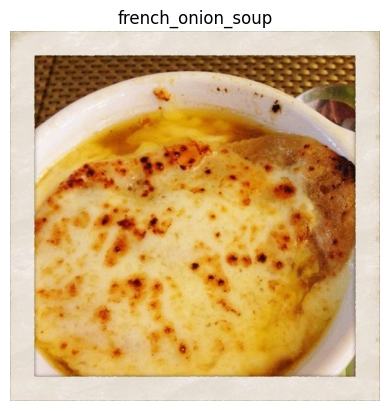

In [62]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the right image
plt.axis(False);

 ## Create preprocessing functions for our data

 Neural networks perform best when data is in a certain way (e.g. batched, normalized, etc).
 However, not all data (including data from TensorFlow Datasets) comes like this.
 So, in order to get the data ready for a neural network, we'll often have to write preprocessing functions and map it to our data.


 What we know about our data:
 * In `uint8` datatype
 * Comprised of all different size tensors (different sized images)
 * Not scaled (the pixel values are between 0 & 255)


 What we know `models` like:
 * Data in `float32` dtype (or for mixed precision `float16` and `float32`)
 * For batches, TensorFlow likes all of the tensors within a batch to be of the same size
 * Scaled (values between 0 & 1) also called normalized tensors generally perform better.



 With these points in mind, we've got a few things we can tackle with a preprocessing function.


 Since we're going to be using an `EfficientNetBX` pretrained model from `tf.keras.applications`, we don't need to rescale our data (these architectures have rescaling build-in).

 This means our functions needs to:
 1. Reshape our images to all the same size.
 2. Convert the dtype of our images tensors from `uint8` to `float32`.

In [63]:
# Make a functions for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' -> 'float32' and reshapes
  image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  # image = image/255. # scale image values (not required with EfficientNetBX models)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [64]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f"Image after preprocessing: \n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[168 148 123]
  [192 172 147]
  [200 180 155]
  ...
  [179 165 139]
  [188 172 147]
  [154 138 113]]

 [[184 164 139]
  [209 189 164]
  [212 192 167]
  ...
  [207 193 167]
  [218 202 177]
  [184 168 143]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing: 
 [[[194.12755 174.12755 149.12755]
  [204.66325 184.66325 159.66325]
  [198.20918 180.42348 158.85204]
  ...
  [200.12253 186.55106 160.97958]
  [204.22949 190.22949 164.22949]
  [195.14168 179.14168 154.14168]]

 [[197.10204 177.10204 150.10204]
  [202.5102  185.5102  159.5102 ]
  [209.96428 193.83673 169.47958]
  ...
  [201.301   187.72952 162.15805]
  [207.8622  193.8622  167.8622 ]
  [197.218   183.218   157.218  ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch and prepare datasets

We're now going to make our data input pipeline run really fast.

For more resources on this: https://www.tensorflow.org/guide/data_performance

In [65]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [66]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

>Using TensorFlow, we map the preprocessing function (`preprocess_img`) across our training dataset, then shuffle a number of elements and then batch them together and finally make sure to prepare new batches (`prefetch`) whilst the model is looking through (`finding patterns`) the current batch.

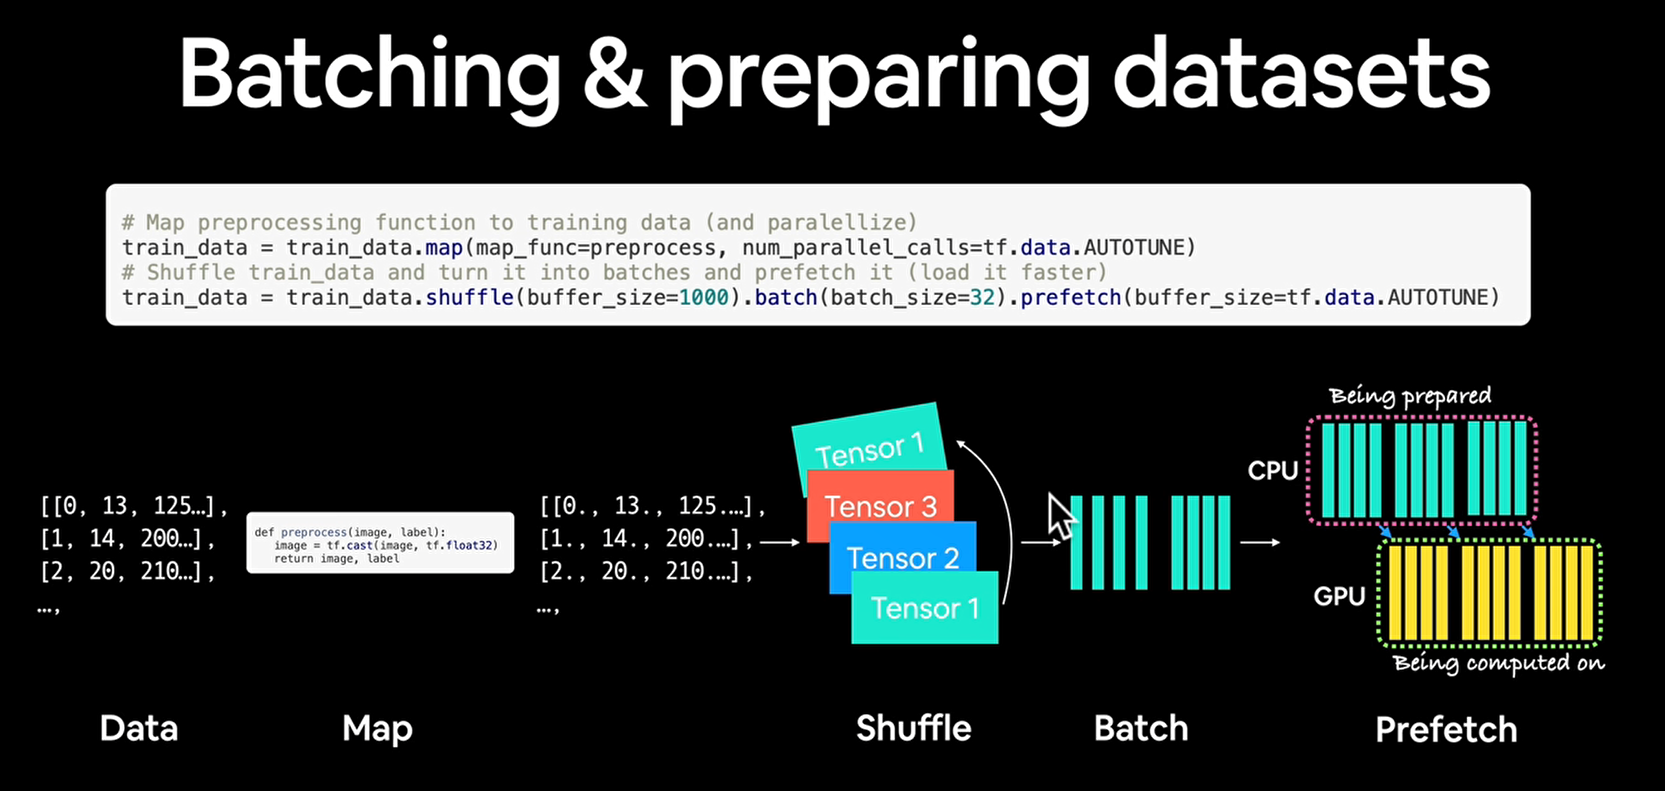

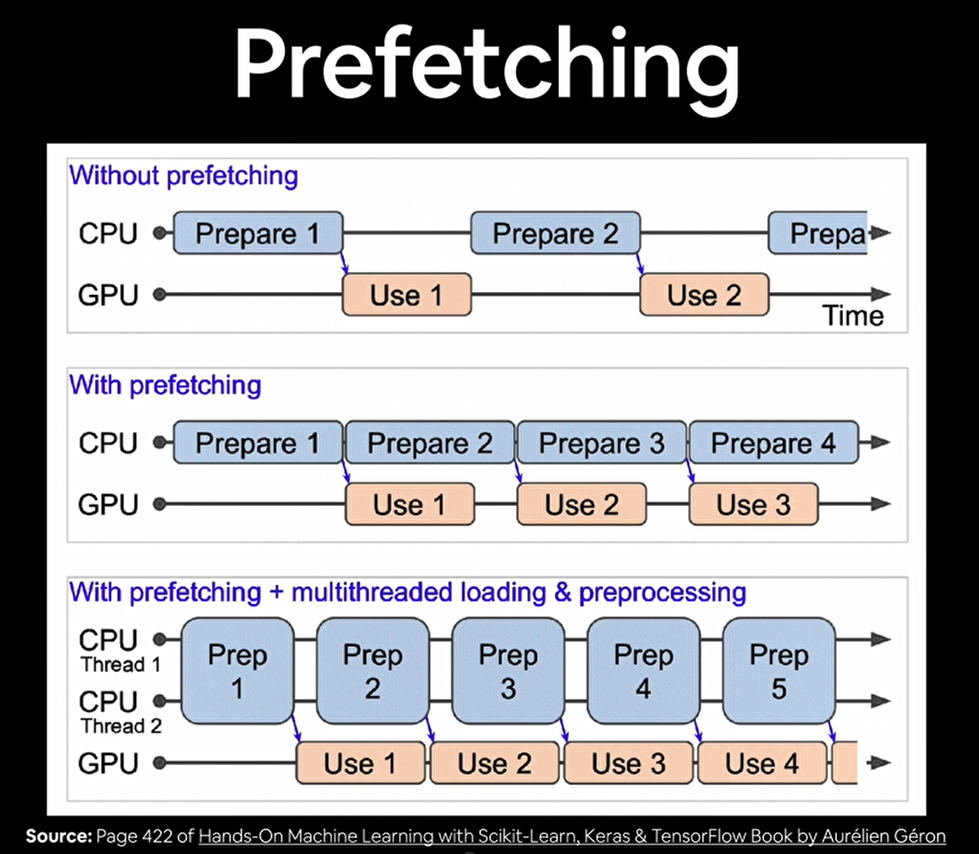

## Creating some modelling callbacks

Different type of callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks

In [67]:
# Create tensorboard callback (import from helper_functions.py).
# The Tensorboard is now officially shutdown.
from helper_functions import create_tensorboard_callback

In [68]:
# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoint/cp.weights.h5"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0) # don't print whether or not model is being saved

# Create EarlyStopping callback to stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # this will monitor the 'val_loss' metric
                                                  patience=0, # Number of epochs with no improvement after which training will be stopped.
                                                  verbose=0) # This callback will stop the training when there is no improvement in the loss for three consecutive epochs.


## Setup mixed precision training

For deeper understanding of mixed precision training, check out the TensorFlow guide for mixed precision: https://www.tensorflow.org/guide/mixed_precision

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [69]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")  # set global data policy to mixed precision

In [70]:
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Build feature extraction model

In [71]:
import tensorflow as tf
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if the model doesn't we can have a layer like below
# x = preprocessing.Rescaling(1/255.)(x)
x = base_model(inputs, training=False) # make sure layers which should be in inference model only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [72]:
 model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_5 (Cast)                   │ (None, 101)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Checking layer dtype policies (are we using mixed precision?)

In [73]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
global_average_pooling2d_2 True float32 <DTypePolicy "mixed_float16">
dense_2 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer.
* `layer.trainable`: is the layer trainable or not? (if `False`, the weights are frozen).
* `layer.dtype`: the data type a layer stores its variables in.
* `layer.dtype_policy`: the data type policy a layer computes on its variables with.

In [74]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers: # check the layers of the base model (layer at index 1 of `model`)
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_2 False float32 <DTypePolicy "mixed_float16">
rescaling_4 False float32 <DTypePolicy "mixed_float16">
normalization_2 False float32 <DTypePolicy "mixed_float16">
rescaling_5 False float32 <DTypePolicy "mixed_float16">
stem_conv_pad False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_dwconv False float32 <DTypePolicy "mixed_float16">
block1a_bn False float32 <DTypePolicy "mixed_float16">
block1a_activation False float32 <DTypePolicy "mixed_float16">
block1a_se_squeeze False float32 <DTypePolicy "mixed_float16">
block1a_se_reshape False float32 <DTypePolicy "mixed_float16">
block1a_se_reduce False float32 <DTypePolicy "mixed_float16">
block1a_se_expand False float32 <DTypePolicy "mixed_float16">
block1a_se_excite False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_fl